# Logistic Regression with Numpy

Here we'll attempt to classify the Iris Flower Dataset with a model that we'll build ourselves. 

**Note:** We won't be using any frameworks, we'll just use numpy and plain python.


## The Iris flower data set / Fisher's Iris data set
 - https://en.wikipedia.org/wiki/Iris_flower_data_set
 - Multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper *The use of multiple measurements in taxonomic problems* as an example of linear discriminant analysis.
 - Input / Feature Names (150 x 4)
     - sepal length (cm)
     - sepal width (cm)
     - petal length (cm)
     - petal width (cm)
 - Output (150 x 1)
    - Iris species label
        0. setosa
        1. versicolor
        2. virginica

- Aim : 
    - Classifying an Iris flower into one of these species based on features
    - ie. Assign a class to given input sample

So as we can see, the dataset consists of **4 input features** and the flowers can be classified as **1 of 3 categorires** as specified above.

## Importing Dependancies

So here are the essentials we'll need to perform the above classification.

*Additionally we'll use matplotlib to visualize the data*

In [26]:
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Loading the Dataset

The dataset comes with sklearn as a standard dataset. So we'll use the datasets module within sklearn to load our data.

In [27]:
iris = datasets.load_iris()

X = iris.data.T # Here we take the transposition of the data matrix. 
y = iris.target.reshape((1,150))

print X.shape
print y.shape
print type(y)
order = np.random.permutation(len(X[1]))

(4, 150)
(1, 150)
<type 'numpy.ndarray'>


## One-Hot Encoding

One-hot or One-of-k is a method we'll use to encode our classes such that **no class has any features that will distinctly differentiate them** and **to ensure all the y-values lie between 0 and 1**.

Hence this is how our data will be modified.

|Original Value| One-Hot Encoded|
|--------------|----------------|
|0| [1, 0, 0]|
|1| [0, 1, 0]|
|2| [0, 0, 1]|

Refer [sklearn OneHotEncoder docs](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for more information. Here since our dataset is small we'll just one-hot encode with a small Python Script.

In [47]:
ohe_y = np.array([[0,0,0]])

for datapoint in y[0]:
    
    if datapoint == 0:
        ohe_y = np.vstack([ohe_y, np.array([1,0,0])])
    elif datapoint == 1:
        ohe_y = np.vstack([ohe_y, np.array([0,1,0])])
    else:
        ohe_y = np.vstack([ohe_y, np.array([0,0,1])])
        
ohe_y = ohe_y[1:,:]
print np.shape(ohe_y)
assert(np.sum(ohe_y, axis=1).all() == 1) # Sanity Check: We're checking that each tuple adds to 1.

(150, 3)


## Splitting Training and Testing Data

Now that we've set up our data let's split it up into **Testing** and **Training** sets.

As we've explained before to proplerly validate our model, we need to ensure that it's trained and tested on mutually exclusive sets of data. 

**Why?**

If we train a model on a set of data, the model will understand the patterns within that dataset and may even perform well during training. But since it's already fit to that data the testing accuracy will be high. Hence we need to ensure that the model is tested on unseen data so as to properly understand it's performance.

In [50]:
# Shuffling data
order = np.random.permutation(len(X[1]))
portion = 30

# Splitting data into train and test 
# samples 0-19  : Test set
# samples 20-99 : Train set
test_x = X[:,order[:portion]]
test_y = ohe_y[order[:portion],:]
train_x = X[:,order[portion:]]
train_y = ohe_y[order[portion:],:]

print ("Training dataset shape")
print (train_x.shape)
print (train_y.shape)

print ("Test dataset shape")
print (test_x.shape)
print (test_y.shape)

Training dataset shape
(4, 120)
(120, 3)
Test dataset shape
(4, 30)
(30, 3)


## Activation Function

Now that we've split our training data into training and testing sets let's move on to the actual model. 
An activation function, as we've explained in class the activation function will define the output of our logit using our weighted features as input.

For a list of various activation functions and their properties [click here](https://en.wikipedia.org/wiki/Activation_function#Comparison%20of%20activation%20functions).

We need an activation function that:

* Flattens the output between the range 0 and 1
* Has very small range within which the output is neither close to 0 or 1.

Hence we'll use the Sigmoid activation function.
It looks like this:

![image](https://cdn-images-1.medium.com/max/1200/1*Vo7UFksa_8Ne5HcfEzHNWQ.png)

In the next cell we'll demonstrate how this function maps an input.

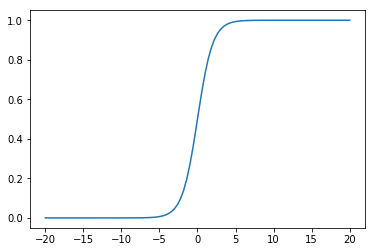

In [55]:
sample_x = np.linspace(-20,20,100)
plt.plot(sample_x,sigmoid(sample_x))
plt.show()

Hence to implement in python we just need to define the following function:

In [56]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

## Hypothesis
The output for a given sample is derived using the following formula
![Output](https://cdn-images-1.medium.com/max/800/1*p4hYc2VwJqoLWwl_mV0Vjw.png)

Here, 
- `g` - Sigmoid Function
- `theta` - Weight Matrix
- `z` - Output
- `h` - Activated Output

In [110]:
def predict(x,theta):
    z = (theta.T).dot(x)
    hx = sigmoid(z)
#     print "Shape after activation: " + str(hx.shape)
    return hx

## Loss

**REFER : https://www.youtube.com/watch?v=K0YBDyxEXKE**
![Loss](https://cdn-images-1.medium.com/max/800/1*FdxEs8Iv_43Q8calTCjnow.png)


In [128]:
def loss(h, y):
    return np.sum(np.negative(y.T) * np.log(h) - (1 - y).T * (np.log(1 - h))) / y.shape[1]

## Gradient
![Grad formula](https://cdn-images-1.medium.com/max/800/1*gobKgGbRWDAoVFAan_HjxQ.png)

In [129]:
def gradient(X,h,y):
    return (1.0 / y.shape[0]) * np.dot(X, (h.T - y))

In [130]:
def get_gradient(theta, b, x, y):
    y_estimate = predict(x,theta)
    error = loss(y_estimate,y)
    grad = gradient(x,y_estimate,y)
    error = np.squeeze(error)
    
    return grad,error

In [133]:
def learn(alpha = 0.000004):
    # Initialising a random vector of weights
    theta = np.zeros((4,3))
    b = 0

    # Learning rate alpha passed as a parameter.
    
    # Threshold to terminate learning
    tolerance = 1e-5
    errorold = 0

    # Perform Gradient Descent
    iterations = 1
    print theta
    print theta.shape
    while True:
        theta_gradient, error = get_gradient(theta, b, train_x, train_y)
        theta_new = theta - (alpha * theta_gradient)

        # Stopping Condition
        if np.sum(abs(theta_new - theta)) < tolerance:
            print ("Converged.")
            break

        # Print error every 50 iterations
        if iterations % 50 == 0:
            print ("Iteration: "+str(iterations)+" - Error: "+ str(np.sum(error)))
    #       break

        iterations += 1

    #     if (error - errorold < 0):
    #         print "Overshot: Iteration - " + str(iterations)  
    #         break

        theta = theta_new
        errorold = error

    return theta, b, error

In [134]:
#Let's train the model:
learn()

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
(4, 3)
Iteration: 50 - Error: 83.12554961664718
Iteration: 100 - Error: 83.07267024803538
Iteration: 150 - Error: 83.02008822180586
Iteration: 200 - Error: 82.96780169310516
Iteration: 250 - Error: 82.91580882725538
Iteration: 300 - Error: 82.86410779972742
Iteration: 350 - Error: 82.81269679611343
Iteration: 400 - Error: 82.76157401209879
Iteration: 450 - Error: 82.71073765343374
Iteration: 500 - Error: 82.66018593590445
Iteration: 550 - Error: 82.6099170853037
Iteration: 600 - Error: 82.55992933740116
Iteration: 650 - Error: 82.51022093791305
Iteration: 700 - Error: 82.46079014247174
Iteration: 750 - Error: 82.4116352165946
Iteration: 800 - Error: 82.36275443565262
Iteration: 850 - Error: 82.31414608483873
Iteration: 900 - Error: 82.26580845913556
Iteration: 950 - Error: 82.21773986328299
Iteration: 1000 - Error: 82.16993861174531
Iteration: 1050 - Error: 82.122403028678
Iteration: 1100 - Error: 82.07513144789425
Iteration: 1150 - Erro

Iteration: 11200 - Error: 76.1951682722534
Iteration: 11250 - Error: 76.1779124540687
Iteration: 11300 - Error: 76.16072924143502
Iteration: 11350 - Error: 76.14361818699876
Iteration: 11400 - Error: 76.1265788463403
Iteration: 11450 - Error: 76.10961077795439
Iteration: 11500 - Error: 76.09271354323049
Iteration: 11550 - Error: 76.07588670643331
Iteration: 11600 - Error: 76.05912983468353
Iteration: 11650 - Error: 76.0424424979385
Iteration: 11700 - Error: 76.02582426897321
Iteration: 11750 - Error: 76.00927472336129
Iteration: 11800 - Error: 75.9927934394562
Iteration: 11850 - Error: 75.97637999837251
Iteration: 11900 - Error: 75.96003398396722
Iteration: 11950 - Error: 75.94375498282143
Iteration: 12000 - Error: 75.92754258422185
Iteration: 12050 - Error: 75.9113963801426
Iteration: 12100 - Error: 75.89531596522714
Iteration: 12150 - Error: 75.8793009367702
Iteration: 12200 - Error: 75.86335089469995
Iteration: 12250 - Error: 75.84746544156017
Iteration: 12300 - Error: 75.8316441824

Iteration: 21750 - Error: 73.65468112008206
Iteration: 21800 - Error: 73.64613214762062
Iteration: 21850 - Error: 73.63760414970243
Iteration: 21900 - Error: 73.62909700997771
Iteration: 21950 - Error: 73.62061061280907
Iteration: 22000 - Error: 73.61214484326678
Iteration: 22050 - Error: 73.60369958712418
Iteration: 22100 - Error: 73.59527473085319
Iteration: 22150 - Error: 73.58687016161967
Iteration: 22200 - Error: 73.57848576727896
Iteration: 22250 - Error: 73.57012143637141
Iteration: 22300 - Error: 73.56177705811788
Iteration: 22350 - Error: 73.5534525224154
Iteration: 22400 - Error: 73.54514771983267
Iteration: 22450 - Error: 73.53686254160584
Iteration: 22500 - Error: 73.52859687963405
Iteration: 22550 - Error: 73.52035062647523
Iteration: 22600 - Error: 73.5121236753418
Iteration: 22650 - Error: 73.50391592009636
Iteration: 22700 - Error: 73.49572725524762
Iteration: 22750 - Error: 73.48755757594608
Iteration: 22800 - Error: 73.47940677797997
Iteration: 22850 - Error: 73.47127

(array([[-0.06434581, -0.061061  , -0.04244112],
        [-0.00265377, -0.04484844, -0.04280933],
        [-0.10871565, -0.02154039,  0.02770059],
        [-0.04314208, -0.00828669,  0.01966167]]), 0, 72.31260772996043)